## Info

In [1]:
# Martingale Betting: Bet the moneyline on a team. If they lose, double the same bet for the same team in their next game.

# The purpose of this notebook is first wave of experiments with Martingale betting system.

# Data sources

# 2021
# https://www.baseball-reference.com/teams/DET/2021-schedule-scores.shtml
# https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers

# 2019
# https://www.baseball-reference.com/teams/DET/2019-schedule-scores.shtml
# https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers/2019

# 2018
# same as above

# note: Covers Line: an average comprised of odds from multiple sportsbooks
# from https://www.covers.com/mlb/dodgers-vs-braves-picks-predictions-october-23-2021

# terminology
# team-season: a specific season for a specific team
# refill factor: the number of games you're guaranteed until another refill
# dataset name: a 5 letter string of the 3-letter team abbreviation (on baseball-reference) + last 2 digits of season year

## Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import matplotlib as mpl
import statistics
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')
from martingale import ds_names, full_run, plot_results, grid_search, param_boxplot

## Functions

*moved to martingale.py*

## Analysis

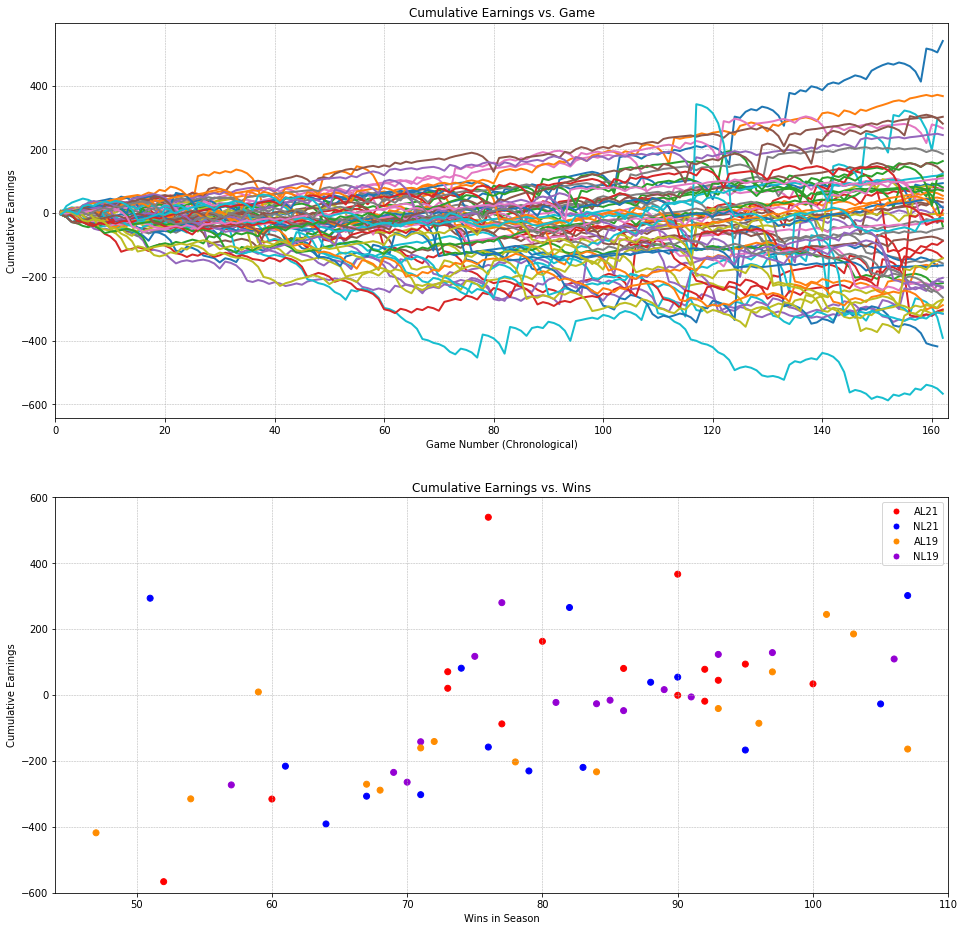

In [3]:
# run once with default parameters
bet_data, team_data = full_run(ds_names())

# plot results
plot_results(bet_data, team_data)

In [4]:
# grid search
params = {'base_bet': [2, 5, 10, 20],
          'start_balance': [25, 50, 100, 200, 1000],
          'refill': [1, 2, 3, 4, 5]
         }
param_gs = grid_search(73, params)

grid search complete


In [5]:
# quick analyze results of grid search
param_gs.sort_values(by=['earn_avg', 'test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))
param_gs.sort_values(by=['pct_pos', 'test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))
param_gs.sort_values(by=['test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))

,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
96,20.0,1000.0,2.0,306.40,1079.74,59.52,0.28
97,20.0,1000.0,3.0,278.42,1126.17,59.52,0.25
98,20.0,1000.0,4.0,278.04,1134.03,61.90,0.25
95,20.0,1000.0,1.0,230.97,1136.46,57.14,0.20
80,20.0,50.0,1.0,184.37,766.86,50.00,0.24


,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
21,2.0,1000.0,2.0,70.46,265.57,88.1,0.27
20,2.0,1000.0,1.0,68.32,273.80,88.1,0.25
23,2.0,1000.0,4.0,68.27,273.96,88.1,0.25
22,2.0,1000.0,3.0,66.25,282.14,88.1,0.23
24,2.0,1000.0,5.0,64.48,289.62,88.1,0.22


,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
11,2.0,100.0,2.0,30.63,107.97,59.52,0.28
96,20.0,1000.0,2.0,306.40,1079.74,59.52,0.28
5,2.0,50.0,1.0,23.61,85.05,52.38,0.28
65,10.0,200.0,1.0,113.24,403.56,50.00,0.28
35,5.0,100.0,1.0,56.63,201.78,50.00,0.28


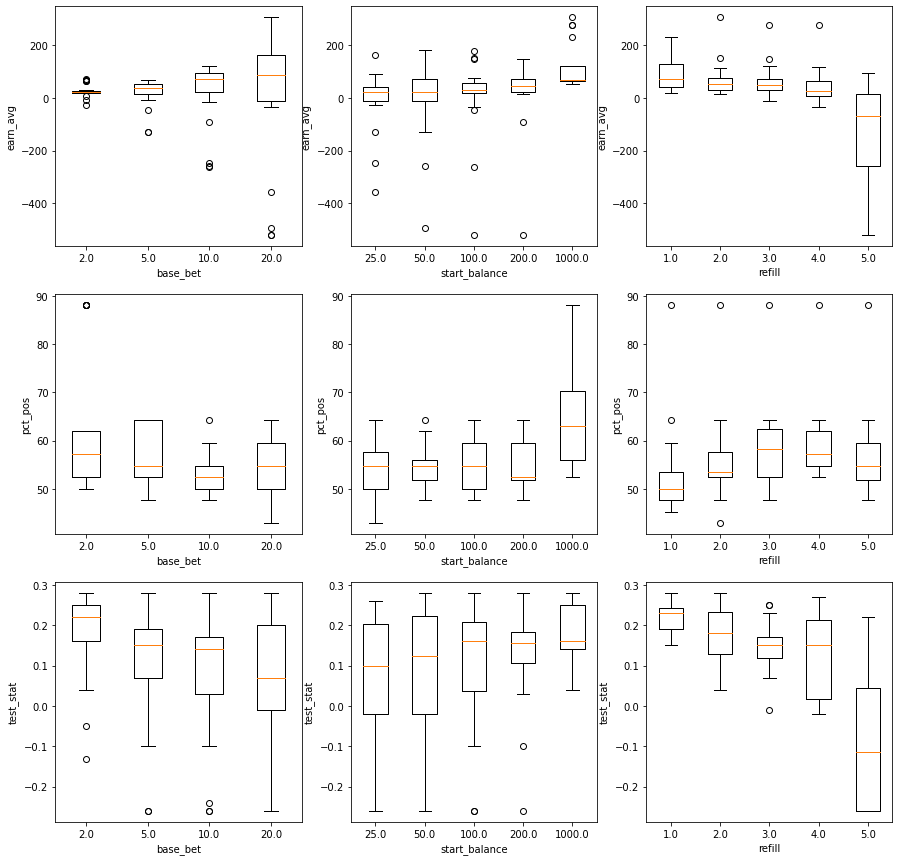

In [6]:
# analyze effect of parameters

mpl.rcParams["figure.figsize"] = [15,15]

plt.subplot(3,3,1)
param_boxplot(param_gs, 'base_bet', 'earn_avg')

plt.subplot(3,3,2)
param_boxplot(param_gs, 'start_balance', 'earn_avg')

plt.subplot(3,3,3)
param_boxplot(param_gs, 'refill', 'earn_avg')

plt.subplot(3,3,4)
param_boxplot(param_gs, 'base_bet', 'pct_pos')

plt.subplot(3,3,5)
param_boxplot(param_gs, 'start_balance', 'pct_pos')

plt.subplot(3,3,6)
param_boxplot(param_gs, 'refill', 'pct_pos')

plt.subplot(3,3,7)
param_boxplot(param_gs, 'base_bet', 'test_stat')

plt.subplot(3,3,8)
param_boxplot(param_gs, 'start_balance', 'test_stat')

plt.subplot(3,3,9)
param_boxplot(param_gs, 'refill', 'test_stat')